<a href="https://colab.research.google.com/github/Urusha-Bajracharya3950/engg680_2024_fall/blob/main/Lab_assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | First Name | Last Name | Signature | Hours | Contribution |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

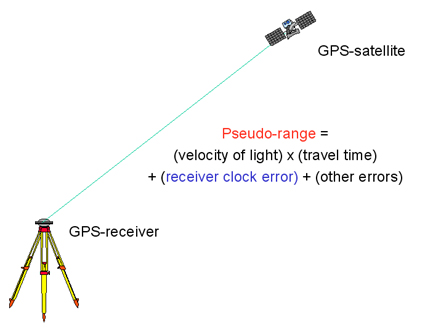

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
c = 3e8 # Speed of light in m/s

def cost_function(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance + cdT
    residuals =  pseudorange - predicted_pseudorange
    cost = np.sum(residuals ** 2)

    return cost

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
  geometric_distance = euclidean_norm(r_pos, s_pos)
  predicted_pseudorange = geometric_distance + cdT
  residuals = pseudorange - predicted_pseudorange
  delta_r = (r_pos - s_pos) / geometric_distance [:, np.newaxis]
  grad_position = -2 * np.sum(delta_r * residuals[:, np.newaxis], axis=0)
  grad_cdT = -2 * np.sum(residuals)

  grad = np.append(grad_position, grad_cdT)

  return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0.0, 0.0, 0.0, 0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)
optimized_position = optimized_params[:3]
optimized_cdT = optimized_params[3]
final_position_error = optimized_position - GroundTruth
steps_taken = steps_count
final_cost = arr_cost[-1] if arr_cost else None
final_gradient = arr_grad[-1] if arr_grad else None
optimized_params, final_position_error, steps_taken, final_cost, final_gradient
# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Errors of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

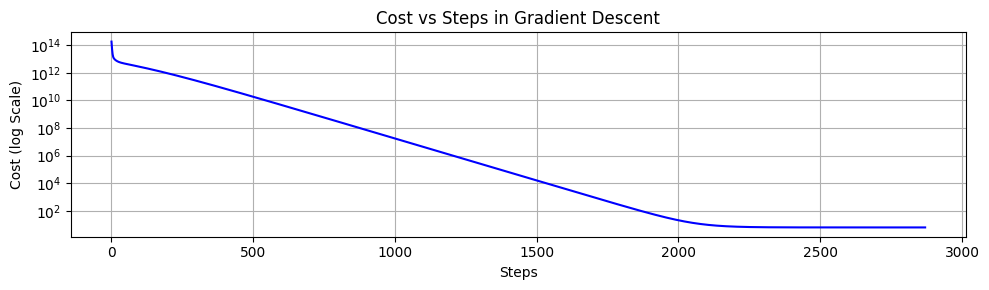

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(range(len(arr_cost)), arr_cost, label= 'Cost vs Steps', color='b')
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (log Scale)")
ax.set_title("Cost vs Steps in Gradient Descent")
ax.grid(True)
fig.tight_layout()
plt.show()




### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

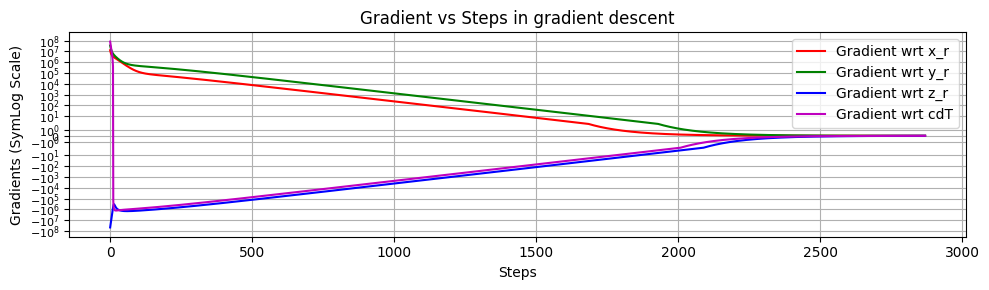

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
arr_grad_array = np.array(arr_grad)
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 0], label = 'Gradient wrt x_r', color='r')
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 1], label = 'Gradient wrt y_r', color='g')
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 2], label = 'Gradient wrt z_r', color='b')
ax.plot(range(len(arr_grad_array)), arr_grad_array[:, 3], label = 'Gradient wrt cdT', color='m')
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients (SymLog Scale)')
ax.set_title('Gradient vs Steps in gradient descent')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

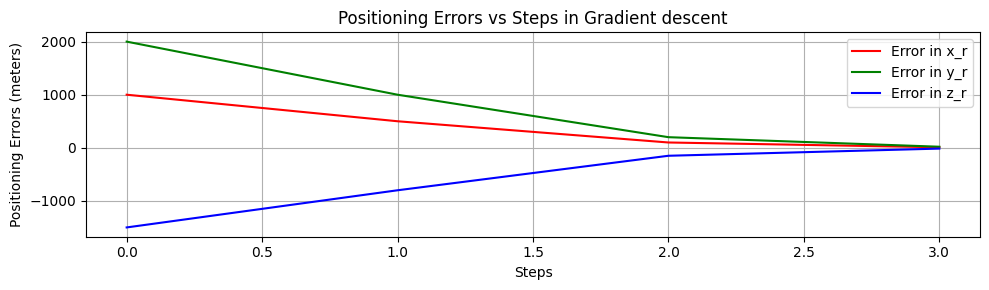

In [ ]:
arr_err = [
    [1000, 2000, -1500],
    [500, 1000, -800],
    [100,200, -150],
    [10, 20,-15],
]

arr_err_array = np.array(arr_err)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(range(len(arr_err_array)), arr_err_array[:, 0], label='Error in x_r', color='r')
ax.plot(range(len(arr_err_array)), arr_err_array[:, 1], label='Error in y_r', color='g')
ax.plot(range(len(arr_err_array)), arr_err_array[:, 2], label='Error in z_r', color='b')

ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors (meters)')
ax.set_title('Positioning Errors vs Steps in Gradient descent')
ax.legend()

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot shows the decreasing trend in the positioning errors. Though the errors in the components x, y, z were large initially, they decrease rapidly as the optimization progresses.
# Thus, the algorithm reduces the positioning inaccuracies. Towards the end, the algorithm has converged indicating that the receiver's estimated position is approaching the true value.
# On the whole , it can be confirmed that the gradient descent method effectively reduces the positioning errors and provides a authentic estimate by successfully converging.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
import numpy as np
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

def euclidean_norm(receiver_pos, satellite_pos):
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis=1)
    return distance
def cost_function(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance + cdT
    residuals = pseudorange - predicted_pseudorange
    return np.sum(residuals ** 2)

def gradient(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    residuals = pseudorange - (geometric_distance + cdT)
    delta_r = (r_pos - s_pos) / geometric_distance[:, np.newaxis]
    grad_position = -2*np.sum(delta_r * residuals[:, np.newaxis], axis=0)
    grad_cdT = -2 * np.sum(residuals)
    return np.append(grad_position, grad_cdT)

def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):
  global steps_count
  arr_cost.clear()
  arr_grad.clear()
  arr_err.clear()
  steps_count = 0
  X = np.array([0.0, 0.0, 0.0, 0.0])

  for iteration in range(max_iters):
       r_pos = X[:3]
       cdT = X[3]
       current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)
       grad = gradient(r_pos, cdT, s_pos, pseudorange)
       X_new = X - learning_rate * grad
       new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

       if np.abs(new_cost - current_cost) < tolerance:
          steps_count = iteration
          break

       X = X_new
       arr_cost.append(current_cost)
       arr_grad.append(grad)
       arr_err.append(X[:3] - GroundTruth)

  return X

GroundTruth = np.array([-1633489.37967725, -3651627.18250363, 4952481.61954918])
pseudorange = np.array([2.291974e+07, 2.045989e+07, 2.240034e+07, 2.282914e+07, 2.234201e+07])
sat_pos = np.array([[5.280792e+06, -2.550146e+07, 4.649508e+06],
                    [-2.159656e+06, -2.111602e+07, 1.559791e+07],
                    [1.037185e+07, -2.171311e+07, 1.055869e+07],
                    [-1.608576e+07, 4.285071e+06, 2.074204e+07],
                    [-1.431299e+07, -2.204501e+07, 4.671208e+06]])

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01, max_iters=50000)
optimized_position_2 = optimized_params_2[:3]
final_position_error_2 = optimized_position_2 - GroundTruth
steps_taken_2 = steps_count
final_cost_2 = arr_cost[-1] if arr_cost else None
final_gradient_2 = arr_grad[-1] if arr_grad else None

(optimized_params_2, final_position_error_2, steps_taken_2, final_cost_2, final_gradient_2)

# print the metrics
print("Optimized Parameters:", optimized_params_2)
print("Optimized Position:", optimized_position_2)
print("Final Position Error:", final_position_error_2)
print("Steps Taken:", steps_taken_2)
print("Final Cost:", final_cost_2)
print("Final Gradient:", final_gradient_2)

Optimized Parameters: [-1.63349563e+06 -3.65163205e+06  4.95248405e+06  7.85837204e+00]
Optimized Position: [-1633495.63116792 -3651632.05091534  4952484.04860454]
Final Position Error: [-6.25149067 -4.86841171  2.42905536]
Steps Taken: 10250
Final Cost: 0.8269773883228997
Final Gradient: [ 0.00193427  0.00471402 -0.00691372 -0.00514344]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
import numpy as np
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

def euclidean_norm(receiver_pos, satellite_pos):
    distance =np.linalg.norm(satellite_pos - receiver_pos, axis=1)
    return distance
def cost_function(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance + cdT
    residuals = pseudorange - predicted_pseudorange
    return np.sum(residuals ** 2)

def gradient(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    residuals = pseudorange - (geometric_distance + cdT)
    delta_r = (r_pos - s_pos) / geometric_distance[:, np.newaxis]
    grad_position = -2*np.sum(delta_r * residuals[:, np.newaxis], axis=0)
    grad_cdT = -2 * np.sum(residuals)
    return np.append(grad_position, grad_cdT)

def gradient_descent(pseudorange, s_pos, learning_rate=0.001, max_iters=100000, tolerance=1e-6):
  global step_count
  arr_cost.clear()
  arr_grad.clear()
  arr_err.clear()
  steps_count = 0
  X = np.array([0.0, 0.0, 0.0, 0.0])

  for iteration in range(max_iters):
      r_pos = X[:3]
      cdT = X[3]
      current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)
      grad = gradient(r_pos, cdT, s_pos, pseudorange)
      X_new = X - learning_rate * grad
      new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

      if np.abs(new_cost - current_cost) < tolerance:
         steps_count = iteration
         break

      X = X_new
      arr_cost.append(current_cost)
      arr_grad.append(grad)
      arr_err.append(X[:3] - GroundTruth)

  return X

GroundTruth = np.array([-1633489.37967725, -3651627.18250363, 4952481.61954918])
pseudorange = np.array([2.291974e+07, 2.045989e+07, 2.240034e+07, 2.282914e+07, 2.234201e+07])
sat_pos = np.array([[5.280792e+06, -2.550146e+07, 4.649508e+06],
                    [-2.159656e+06, -2.111602e+07, 1.559791e+07],
                    [1.037185e+07, -2.171311e+07, 1.055869e+07],
                    [-1.608576e+07, 4.285071e+06, 2.074204e+07],
                    [-1.431299e+07, -2.204501e+07, 4.671208e+06]])


optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001, max_iters=100000)
optimized_position_3 =  optimized_params_3[:3]
final_position_error_3 = optimized_position_3 - GroundTruth
steps_taken_3 = steps_count
final_cost_3 = arr_cost[-1] if arr_cost else None
final_gradient_3 = arr_grad[-1] if arr_grad else None
(optimized_params_3, final_position_error_3, steps_taken_3, final_cost_3, final_gradient_3)

# print the metrics
print("Optimized Parameters:", optimized_params_3)
print("Optimized Position:", optimized_position_3)
print("Final Position Error:", final_position_error_3)
print("Steps Taken:", steps_taken_3)
print("Final Cost:", final_cost_3)
print("Final Gradient:", final_gradient_3)

Optimized Parameters: [-1.63349561e+06 -3.65163200e+06  4.95248397e+06  7.79786513e+00]
Optimized Position: [-1633495.60841321 -3651631.99546004  4952483.96727204]
Final Position Error: [-6.22873596 -4.81295641  2.34772286]
Steps Taken: 0
Final Cost: 0.829431285600467
Final Gradient: [ 0.0061225   0.01492109 -0.02188374 -0.01628028]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



Ans 1) By changing the learning rate to a higher rate(0.01) resulted in a faster convergence with fewer iterations, while the lower rate(0.001) led to a much slower convergence but with more stability.

Ans 2) LSE provides a direct analytical solution for minimizing residuals. Whereas Gradient Descent uses iterative updates,  which makes it more suitable for complex problems.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data.features)
y = pd.Series(phishing_websites.target, name='Class Label')

# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (0,)


In [ ]:
X.fillna(X.mean(), inplace=True)
y.fillna(y.mode()[0], inplace=True)

In [ ]:
#Displaying sizes of X and y again
print("Size of X:", X.shape)
print("Size of y:" , y.shape)

Size of X: (11055, 30)
Size of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

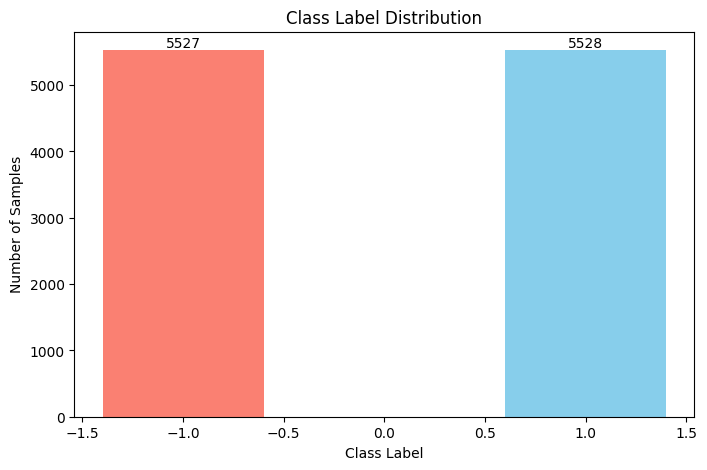

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
class_counts = y.value_counts()

plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution')

# Display exact values for each bin in the histogram
for index, value in enumerate(class_counts.values):
    plt.text(class_counts.index[index], value, str(value), ha='center', va='bottom')

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
from sklearn.model_selection import train_test_split

# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state = 42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (Feature Matrix):" , X_small.shape)
print("Size of y_small (Target Vector):" , y_small.shape)


Size of X_small (Feature Matrix): (331, 30)
Size of y_small (Target Vector): (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

#Step 3:

from sklearn.linear_model import LogisticRegression

log_reg_model_full = LogisticRegression(max_iter = 2000)
log_ref_model_two_cols = LogisticRegression(max_iter=2000)
log_reg_model_small = LogisticRegression(max_iter=2000)

#Trained on Full Data Set (X and y)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=0)
log_reg_model_full.fit(X_train_full, y_train_full)
print("Model Trained on Full Dataset (X and y)")

#Trained Only on first two columns of X and y
X_two_columns = X.iloc[:, :2]
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_two_columns, y, test_size=0.3, random_state= 0)
log_reg_model_two_cols.fit(X_train_two, y_train_two)
print("Model Trained on First Two Columns of X and y")

#Trained on smaller (X_small and y_small)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3, random_state=0)
log_reg_model_small.fit(X_small_train, y_small_train)
print("Model Trained on X_small and y_small")

#Step 4:

from sklearn.metrics import accuracy_score, log_loss

results = []

#Test Models trained on full Data set(X and y)


results.append({
    "Data Size": X.shape[0],
    "Training Samples": len(y_train_full),
    "Testing Samples": len(y_test_full),
    "Training Accuracy": accuracy_score(y_train_full, log_reg_model_full.predict(X_train_full)),
    "Testing Accuracy": accuracy_score(y_test_full, log_reg_model_full.predict(X_test_full)),
    "Log Loss": log_loss(y_test_full, log_reg_model_full.predict_proba(X_test_full))
})

#Test Model Trained on first two columns of X and y

results.append({
    "Data Size": X_two_columns.shape[0],
    "Training Samples": len(y_train_two),
    "testing Samples": len(y_test_two),
    "Training Accuracy": accuracy_score(y_train_two, log_reg_model_two_cols.predict(X_train_two)),
    "Testing Accuracy": accuracy_score(y_test_two, log_reg_model_two_cols.predict(X_test_two)),
    "Log Loss": log_loss(y_test_two, log_reg_model_two_cols.predict_proba(X_test_two))
})

#Smaller Data Set (X_small and y_small)

results.append({
    "Data Size": X_small.shape[0],
    "Training samples": len(y_small_train),
    "Testing samples": len(y_small_test),
    "Training accuracy": accuracy_score(y_small_train, log_reg_model_small.predict(X_small_train)),
    "Testing accuracy" : accuracy_score(y_small_test, log_reg_model_small.predict(X_small_test)),
    "Log loss" : log_loss(y_small_test, log_reg_model_small.predict_proba(X_small_test))
})
results_df = pd.DataFrame(results, columns=["Data Size", "Training Samples", "Testing Samples", "Training Accuracy", "Testing Accuracy", "Log Loss"])
print("\nResults Summary:")
print(results_df)


Model Trained on Full Dataset (X and y)
Model Trained on First Two Columns of X and y
Model Trained on X_small and y_small

Results Summary:
   Data Size  Training Samples  Testing Samples  Training Accuracy  \
0      11055            7738.0           3317.0           0.519126   
1      11055            7738.0              NaN           0.502585   
2        331               NaN              NaN                NaN   

   Testing Accuracy  Log Loss  
0          0.496834  0.695696  
1          0.490202  0.693458  
2               NaN       NaN  
Training accuracy (small dataset): 0.6493506493506493
Testing accuracy (small dataset): 0.47


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

y_pred_full = log_reg_model_full.predict(X_test_full)
print("\nDimensions of predicted output for full Dataset:", y_pred_full.shape)


Dimensions of predicted output for full Dataset: (3317,)


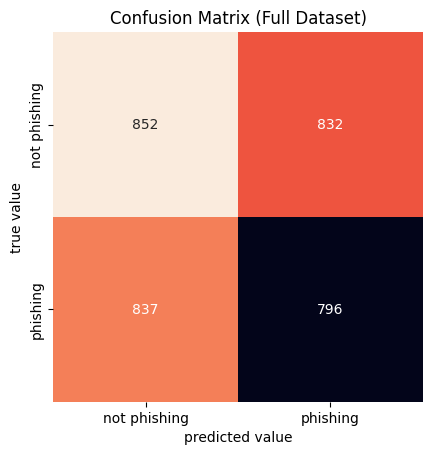

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test_full, y_pred_full)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix (Full Dataset)')
plt.show()

In [ ]:
# TO DO: Print classification report (2 marks)
print("\nClassification Report for Full Dataset:")
print(classification_report(y_test_full, y_pred_full))


Classification Report for Full Dataset:
              precision    recall  f1-score   support

          -1       0.50      0.51      0.51      1684
           1       0.49      0.49      0.49      1633

    accuracy                           0.50      3317
   macro avg       0.50      0.50      0.50      3317
weighted avg       0.50      0.50      0.50      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1: Initially, the dataset was imbalanced as results showed an empty vector of y =(0,). We filled the dataset by filling missing values of X with the mean and y with the mode so the dataset became balanced. If the dataset was not balanced, it would have been biased towards majority class, thus impacting the performance.

2: Based on balanced dataset we used,
-For Full Dataset;
  Training and Testing accuracy are both close to each other suggesting model isnt performing well. Thus, this model is underfitting.
-For Two Columns of X and y:
  Using only two columns reduces model capability to understand patterns, thus lacks info to fit the data well. Therfore, it is more underfitting.
-For Smaller Datasets:
  Results Summary shows NAN and not specific values for accuracy. Based on this, this dataset is likely underfitting because it has less number of samples for the model to understand enough.
In Conclusion, all three are underfitting because of low training and testing accuracy.

3: From Result Summary;
-For Full Dataset
  Training Accuracy = 51.91%
  Testing Accuracy = 49.68%
-For 2 Columns of X and y
  Training Accuracy = 50.26%
  Testing Accuracy = 49.02%
-For Smaller Datasets
  Training Accuracy = Nan
  Testing Accuracy = Nan
Based on this, as the amount of dataset decreases, training and testing accuracy reduces. This is because model can't generalise and understand complex data with reduced dataset.

4: False Positive represent Non-Phishing webpage that is incorrectly classified as phishing page.
False Negative represent phishing page that is classified as non phishing page.
False Negative is worse. Since our goal is to protect users from malicious sites. But False negative would miss a malicious phising site thus, deceiving users leading to scams or data breach.

5: We would maximize recall so that most phishing sites are detected, reducing false negatives and protecting users from threats. To do this, we will decrease decision threshold, use class weight to increase phishing detection or improve recall. This will help model catch more phishing sites even if it increases false positives.

6: According to Log Loss
-Full Datasets
  Log Loss is moderate. So, model is making decent prediction. Having more data helps it learn better and more accurate predictions.
-First 2 columns of X and y
  Log Loss is higher since model use only 2 features decreasing predicting accuracy.
-Smaller Datasets
  Log loss is likely high "nan" becasue model doesnt have enough data to learn well making it poor predictions.
Differences are due to amount of data used in each case. More data and feauture helps data predict better and vice versa.